In [38]:
# normalizing flow as correction to TT-IRT
import numpy as np
import scipy as sp
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
from IPython.display import HTML
import math
import os

# very high precision
torch.set_default_dtype(torch.float64)

import torch.optim as optim

# return to original code: https://github.com/acids-ircam/pytorch_flows/blob/master/flows_04.ipynb

# use normalizing flow as correction
# cite: https://github.com/acids-ircam/pytorch_flows/blob/master/flows_04.ipynb
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            # use random parameters
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)
    
    # forward evaluation: x = f(z)
    def forward(self, z):
        pass

# Main class for normalizing flow
class NormalizingFlow(nn.Module):
    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            if blocks is None:
                # by default uses Planar flow, which does not have inverse abiity
                biject.append(PlanarFlow(dim))
            else:
                # alternate among the blocks
                for flow in blocks:
                    biject.append(flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        #self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det


class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

# Affine coupling flow
class AffineCouplingFlow(Flow):
    def __init__(self, dim, n_hidden=64, n_layers=3, activation=nn.ReLU):
        super(AffineCouplingFlow, self).__init__()
        self.k = dim // 2
        self.g_mu = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.g_sig = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.init_parameters()
        self.bijective = True

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            net.append(nn.Linear(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden))
            net.append(activation())
        return nn.Sequential(*net)
        
    def _call(self, z):
        z_k, z_D = z[:, :self.k], z[:, self.k:]
        zp_D = z_D * torch.exp(self.g_sig(z_k)) + self.g_mu(z_k)
        return torch.cat((z_k, zp_D), dim = 1)

    def _inverse(self, z):
        zp_k, zp_D = z[:, :self.k], z[:, self.k:]
        z_D = (zp_D - self.g_mu(zp_k)) / self.g_sig(zp_k)
        return torch.cat((zp_k, z_D))

    def log_abs_det_jacobian(self, z):
        z_k = z[:, :self.k]
        return -torch.sum(torch.abs(self.g_sig(z_k)))
    

class ReverseFlow(Flow):

    def __init__(self, dim):
        super(ReverseFlow, self).__init__()
        self.permute = torch.arange(dim-1, -1, -1)
        self.inverse = torch.argsort(self.permute)

    def _call(self, z):
        return z[:, self.permute]

    def _inverse(self, z):
        return z[:, self.inverse]

    def log_abs_det_jacobian(self, z):
        return torch.zeros(z.shape[0], 1)
    
class ShuffleFlow(ReverseFlow):

    def __init__(self, dim):
        super(ShuffleFlow, self).__init__(dim)
        self.permute = torch.randperm(dim)
        self.inverse = torch.argsort(self.permute)
    
    
class BatchNormFlow(Flow):

    def __init__(self, dim, momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        # Running batch statistics
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
        # Momentum
        self.momentum = momentum
        self.eps = eps
        # Trainable scale and shift (cf. original paper)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def _call(self, z):
        if self.training:
            # Current batch stats
            self.b_mean = z.mean(0)
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # Running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) * self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y
        
    def log_abs_det_jacobian(self, z):
        # Here we only need the variance
        mean = z.mean(0)
        var = (z - mean).pow(2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)

In [39]:
# load 11d Rosen sample data
data_ginz = scipy.io.loadmat("./data/double_rosen_full_rank.mat")
display(data_ginz.keys())

dict_keys(['__header__', '__version__', '__globals__', 'C', 'M_xg', 'Ns', 'X', 'X_bad', 'X_bad_test', 'X_bad_train', 'X_test', 'X_train', 'a_xg', 'all_A', 'all_spacings', 'all_xg', 'b_xg', 'coeff_tt', 'cov_samp', 'd', 'dim', 'exact_variance', 'i', 'inp', 'k', 'legendre_ord', 'likes', 'likes_bad', 'likes_bad_test', 'likes_bad_train', 'likes_test', 'likes_train', 'mu_samp', 'p', 'r_func', 'None', 's', 'save_X', 'tol', 'xg', '__function_workspace__'])

In [40]:
# training data from truncated TT and compare with Gaussian
use_gaussian_prior = True
if use_gaussian_prior:
    training_data = data_ginz['X_bad_train'].T
    test_data = data_ginz['X_bad_test'].T
    log_training_data_densities = np.log(data_ginz['likes_bad_train'])
    log_test_data_densities = np.log(data_ginz['likes_bad_test'])
else:
    training_data = data_ginz['X_train'].T
    test_data = data_ginz['X_test'].T
    log_training_data_densities = np.log(data_ginz['likes_train'])
    log_test_data_densities = np.log(data_ginz['likes_test'])
# training data (Gaussian)
print("====== shape of training data = {}".format(training_data.shape))
num_samples = training_data.shape[0]
rosen_dim = training_data.shape[1]

====== shape of training data = (2500, 11)


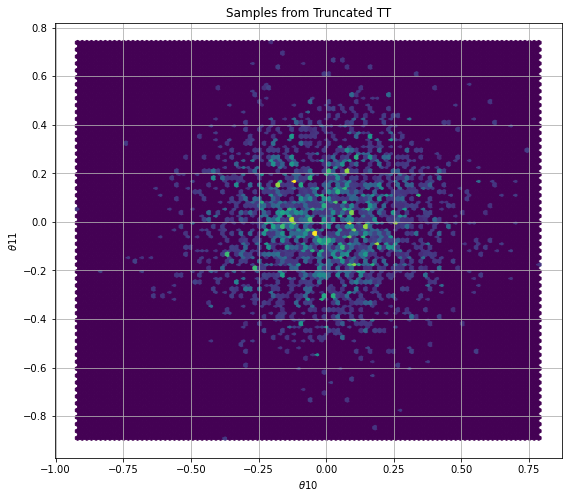

In [41]:
# set random seed
np.random.seed(10)
data_idx = np.random.randint(0, training_data.shape[0], 100*num_samples)
plt.figure(figsize=(20,8));
plt.subplot(1,2,1); plt.grid(True); 
plt.xlabel("$\\theta {}$".format(rosen_dim-1)); 
plt.ylabel("$\\theta {}$".format(rosen_dim)); 
plt.title("Samples from Truncated TT"); 
plot_data_trunc = training_data[data_idx, :]
# plotting the last dimension, long tail
plt.hexbin(plot_data_trunc[:,rosen_dim-2], plot_data_trunc[:,rosen_dim-1]);

We need a trick to evaluate the loss stably (without causing underflow). See: https://mc-stan.org/docs/2_23/stan-users-guide/log-sum-of-exponentials.html for a reference on stable computer algebra.

We have the double Rosenbrock:
$$
    r(\theta) \propto \frac12r_{+}(\theta) + \frac12r_{-}(\theta)
$$ where $r_{+},r_{-}$ are respectively upper and lower half of the double Rosenbrock function.

Here $r_{+}(\theta) \propto \exp(-\frac12E_{+}(\theta))$, $r_{-}(\theta) \propto \exp(-\frac12E_{-}(\theta))$, where $E_{+},E_{-}$ are "energy" of the sampled parameters $\theta$. In loss evaluation, we must evaluate:
$$
    \log r(\theta) = \log (\frac12 (r_+(\theta) + r_-(\theta))) = \log (\exp(-\frac12E_+) + \exp(-\frac12E_-)) -\log 2
$$

This a case of "log-sum-exponential function". We let $u = -\frac12E_+$, $v = -\frac12E_-$, then:
$$
    \log r + \log 2 = u + \log (1 + \exp(v - u)) = -\frac12E_+ + \log(1 + \exp(\frac12(E_+ - E_-)))
$$

In [42]:
# define Rosenbrock function for density evaluation
def rosen_energy(theta):
    """ theta is a torch tensor in R^(Nxd). Assuming from [-1,1]. """
    d = np.shape(theta)[1]
    result = 0
    for k in range(d-1):
        if k <= d-4:
            # theta1, theta2, ..., theta_d-4, theta_d-3 are scaled by 2
            result += (2 * theta[:, k])**2 + ( (2 * theta[:, k+1]) + 5 * ( ( 2*theta[:, k] ) ** 2 + 1 ) )**2
        elif k == d-3:
            # theta d-2 is scaled by 2, theta d-1 is scaled by 7
            result += (2*theta[:, k])**2 + ( (7*theta[:, k+1]) + 5 * ( ( 2*theta[:, k] ) ** 2 + 1 ) )**2
        else:
            # theta d-1 is scaled by 7, theta d is scaled by 200
            result += (7*theta[:, k])**2 + ( (200*theta[:, k+1]) + 5 * ( ( 7*theta[:, k] ) ** 2 + 1 ) )**2
    return result

def rosen_minus_energy(theta):
    """ theta is a torch tensor in R^(Nxd). Assuming from [-1,1]. """
    d = np.shape(theta)[1]
    result = 0
    for k in range(d-1):
        if k <= d-4:
            # theta1, theta2, ..., theta_d-4, theta_d-3 are scaled by 2
            result += (2 * theta[:, k])**2 + ( (2 * theta[:, k+1]) + 5 * ( ( 2*theta[:, k] ) ** 2 + 1 ) )**2
        elif k == d-3:
            # theta d-2 is scaled by 2, theta d-1 is scaled by 7
            result += (2*theta[:, k])**2 + ( (7*theta[:, k+1]) + 5 * ( ( 2*theta[:, k] ) ** 2 + 1 ) )**2
        else:
            # theta d-1 is scaled by 7, theta d is scaled by 200
            result += (7*theta[:, k])**2 + ( (200*(-theta[:, k+1])) + 5 * ( ( 7*theta[:, k] ) ** 2 + 1 ) )**2
    return result

def rosen(theta):
    """ theta is a torch tensor in R^(Nxd). Assuming from [-1,1]. """
    d = np.shape(theta)[1]
    # formula from paper: An n-dimensional Rosenbrock Distribution
    # unknown partition function
    result = 0
    for k in range(d-1):
        if k <= d-4:
            # theta1, theta2, ..., theta_d-4, theta_d-3 are scaled by 2
            result += (2 * theta[:, k])**2 + ( (2 * theta[:, k+1]) + 5 * ( ( 2*theta[:, k] ) ** 2 + 1 ) )**2
        elif k == d-3:
            # theta d-2 is scaled by 2, theta d-1 is scaled by 7
            result += (2*theta[:, k])**2 + ( (7*theta[:, k+1]) + 5 * ( ( 2*theta[:, k] ) ** 2 + 1 ) )**2
        else:
            # theta d-1 is scaled by 7, theta d is scaled by 200
            result += (7*theta[:, k])**2 + ( (200*theta[:, k+1]) + 5 * ( ( 7*theta[:, k] ) ** 2 + 1 ) )**2
    return torch.exp(-0.5*result)

def rosen_minus(theta):
    """ theta is a torch tensor in R^(Nxd). Assuming from [-1,1]. 
    The upper half of double Rosenbrock. """
    d = np.shape(theta)[1]
    # formula from paper: An n-dimensional Rosenbrock Distribution
    # unknown partition function
    result = 0
    for k in range(d-1):
        if k <= d-4:
            # theta1, theta2, ..., theta_d-4, theta_d-3 are scaled by 2
            result += (2 * theta[:, k])**2 + ( (2 * theta[:, k+1]) + 5 * ( ( 2*theta[:, k] ) ** 2 + 1 ) )**2
        elif k == d-3:
            # theta d-2 is scaled by 2, theta d-1 is scaled by 7
            result += (2*theta[:, k])**2 + ( (7*theta[:, k+1]) + 5 * ( ( 2*theta[:, k] ) ** 2 + 1 ) )**2
        else:
            # theta d-1 is scaled by 7, theta d is scaled by 200
            result += (7*theta[:, k])**2 + ( (200*(-theta[:, k+1])) + 5 * ( ( 7*theta[:, k] ) ** 2 + 1 ) )**2
    return torch.exp(-0.5*result)


def double_rosen(theta):
    """ theta is a torch tensor in R^(Nxd). Assuming from [-1,1]. 
    Mixture Rosenbrock distribution: 0.5 * rosen+(theta) + 0.5 * rosen-(theta) """
    return 0.5 * rosen(theta) + 0.5 * rosen_minus(theta)

def loss_kl_3(log_prior_distrib, targ_distrib, z0, zk, log_jacobians):
    """ sae as LOSS_KL() but:
        - log_prior_distrib is predetermined as passed in as a torch.Tensor
        - targ_distrib is callable, rather than PyTorch distribution. 
    """
    sum_of_log_jacobians = sum(log_jacobians)
    #return (log_prior_distrib - sum_of_log_jacobians + (1/2) * rosen_energy(zk)).mean()
    #return (log_prior_distrib - sum_of_log_jacobians + torch.log(targ_distrib(zk))).mean()
    # see: https://mc-stan.org/docs/2_23/stan-users-guide/log-sum-of-exponentials.html
    # to evaluate stably, we use the log-sum-exponential trick
    E_plus = -0.5 * rosen_energy(zk)
    E_minus = -0.5 * rosen_minus_energy(zk)
    c = torch.max(E_plus, E_minus)
    log_targ_density = c + torch.log(torch.exp(E_plus - c) + torch.exp(E_minus - c))
    return (log_prior_distrib - sum_of_log_jacobians - log_targ_density).mean()

In [43]:
# begin training
# useless cell
flow_type = "planar" # autoregressive
if flow_type == "planar":
    rosen_planar_flow = NormalizingFlow(dim=rosen_dim, blocks=None, flow_length=32, density=None)
elif flow_type == "autoregressive":
    block_real_nvp = [ AffineCouplingFlow, ReverseFlow, BatchNormFlow ]
    rosen_planar_flow = NormalizingFlow(dim=rosen_dim, blocks=block_real_nvp, flow_length=12, \
                                        density=None)

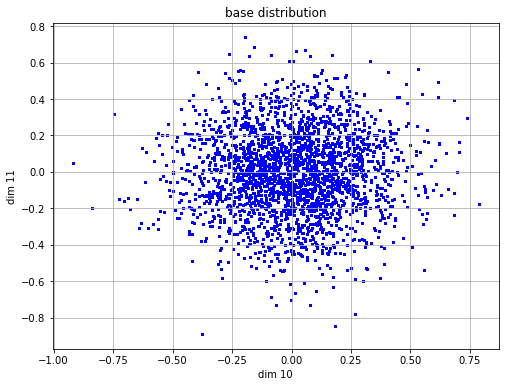

In [44]:
# plot a sample from training data
plot_data = training_data[data_idx, :]
plt.figure(figsize=(8,6)); plt.grid(True); plt.xlabel("dim 10"); plt.ylabel("dim 11");
plt.title("base distribution");
plt.scatter(plot_data[:,rosen_dim-2], plot_data[:,rosen_dim-1], color="blue", s=2);

(Epoch 0, Batch 0) Negtive Log-Likelihood Training Err: 971.0401314100902
(Epoch 0, Batch 0) Negtive Log-Likelihood Generalization Err: 836.7038500550761
(Epoch 0, Batch 5) Negtive Log-Likelihood Training Err: 873.1258735199846
(Epoch 0, Batch 5) Negtive Log-Likelihood Generalization Err: 835.9507093767467
(Epoch 1, Batch 0) Negtive Log-Likelihood Training Err: 956.4677587296501
(Epoch 1, Batch 0) Negtive Log-Likelihood Generalization Err: 834.7846568852207
(Epoch 1, Batch 5) Negtive Log-Likelihood Training Err: 863.1771917548449
(Epoch 1, Batch 5) Negtive Log-Likelihood Generalization Err: 832.9927728333452
(Epoch 2, Batch 0) Negtive Log-Likelihood Training Err: 943.3901230107518
(Epoch 2, Batch 0) Negtive Log-Likelihood Generalization Err: 830.4328545026909
(Epoch 2, Batch 5) Negtive Log-Likelihood Training Err: 917.1524962438164
(Epoch 2, Batch 5) Negtive Log-Likelihood Generalization Err: 827.0948272594167
(Epoch 3, Batch 0) Negtive Log-Likelihood Training Err: 1086.0780452793026
(

(Epoch 26, Batch 5) Negtive Log-Likelihood Training Err: 190.1427136842043
(Epoch 26, Batch 5) Negtive Log-Likelihood Generalization Err: 182.01354135132271
(Epoch 27, Batch 0) Negtive Log-Likelihood Training Err: 184.1498169154659
(Epoch 27, Batch 0) Negtive Log-Likelihood Generalization Err: 180.99123627781756
(Epoch 27, Batch 5) Negtive Log-Likelihood Training Err: 179.47293299945937
(Epoch 27, Batch 5) Negtive Log-Likelihood Generalization Err: 179.99936696652622
(Epoch 28, Batch 0) Negtive Log-Likelihood Training Err: 186.8014756774878
(Epoch 28, Batch 0) Negtive Log-Likelihood Generalization Err: 179.1471275766135
(Epoch 28, Batch 5) Negtive Log-Likelihood Training Err: 180.6991506528019
(Epoch 28, Batch 5) Negtive Log-Likelihood Generalization Err: 178.35876454069316
(Epoch 29, Batch 0) Negtive Log-Likelihood Training Err: 178.31323800639132
(Epoch 29, Batch 0) Negtive Log-Likelihood Generalization Err: 177.7091268869462
(Epoch 29, Batch 5) Negtive Log-Likelihood Training Err: 1

(Epoch 53, Batch 0) Negtive Log-Likelihood Training Err: 163.85882163751376
(Epoch 53, Batch 0) Negtive Log-Likelihood Generalization Err: 161.4060285317045
(Epoch 53, Batch 5) Negtive Log-Likelihood Training Err: 159.14048720729153
(Epoch 53, Batch 5) Negtive Log-Likelihood Generalization Err: 161.1971701154702
(Epoch 54, Batch 0) Negtive Log-Likelihood Training Err: 159.96949903563956
(Epoch 54, Batch 0) Negtive Log-Likelihood Generalization Err: 160.95042403433098
(Epoch 54, Batch 5) Negtive Log-Likelihood Training Err: 161.6368028178512
(Epoch 54, Batch 5) Negtive Log-Likelihood Generalization Err: 160.73708122393262
(Epoch 55, Batch 0) Negtive Log-Likelihood Training Err: 159.7037964645022
(Epoch 55, Batch 0) Negtive Log-Likelihood Generalization Err: 160.53233630807162
(Epoch 55, Batch 5) Negtive Log-Likelihood Training Err: 161.16165196835826
(Epoch 55, Batch 5) Negtive Log-Likelihood Generalization Err: 160.3508744807719
(Epoch 56, Batch 0) Negtive Log-Likelihood Training Err: 

(Epoch 79, Batch 5) Negtive Log-Likelihood Training Err: 152.31920216662996
(Epoch 79, Batch 5) Negtive Log-Likelihood Generalization Err: 153.03723322405
(Epoch 80, Batch 0) Negtive Log-Likelihood Training Err: 152.21285984039707
(Epoch 80, Batch 0) Negtive Log-Likelihood Generalization Err: 152.90038205429772
(Epoch 80, Batch 5) Negtive Log-Likelihood Training Err: 152.93426432108328
(Epoch 80, Batch 5) Negtive Log-Likelihood Generalization Err: 152.78798613639552
(Epoch 81, Batch 0) Negtive Log-Likelihood Training Err: 149.81282490099377
(Epoch 81, Batch 0) Negtive Log-Likelihood Generalization Err: 152.64492418817017
(Epoch 81, Batch 5) Negtive Log-Likelihood Training Err: 154.36864524897078
(Epoch 81, Batch 5) Negtive Log-Likelihood Generalization Err: 152.52777264814563
(Epoch 82, Batch 0) Negtive Log-Likelihood Training Err: 153.71375919460183
(Epoch 82, Batch 0) Negtive Log-Likelihood Generalization Err: 152.42037647558067
(Epoch 82, Batch 5) Negtive Log-Likelihood Training Err

(Epoch 105, Batch 5) Negtive Log-Likelihood Training Err: 146.06416408381642
(Epoch 105, Batch 5) Negtive Log-Likelihood Generalization Err: 146.76682415091918
(Epoch 106, Batch 0) Negtive Log-Likelihood Training Err: 149.04701816018127
(Epoch 106, Batch 0) Negtive Log-Likelihood Generalization Err: 146.71517684455668
(Epoch 106, Batch 5) Negtive Log-Likelihood Training Err: 146.1418362831084
(Epoch 106, Batch 5) Negtive Log-Likelihood Generalization Err: 146.54532952517758
(Epoch 107, Batch 0) Negtive Log-Likelihood Training Err: 146.5112163153451
(Epoch 107, Batch 0) Negtive Log-Likelihood Generalization Err: 146.45595483231867
(Epoch 107, Batch 5) Negtive Log-Likelihood Training Err: 147.18136233038982
(Epoch 107, Batch 5) Negtive Log-Likelihood Generalization Err: 146.41011102199374
(Epoch 108, Batch 0) Negtive Log-Likelihood Training Err: 145.28223497605833
(Epoch 108, Batch 0) Negtive Log-Likelihood Generalization Err: 146.29416053284618
(Epoch 108, Batch 5) Negtive Log-Likelihoo

(Epoch 131, Batch 5) Negtive Log-Likelihood Training Err: 143.17765104931783
(Epoch 131, Batch 5) Negtive Log-Likelihood Generalization Err: 142.94038900173976
(Epoch 132, Batch 0) Negtive Log-Likelihood Training Err: 143.08118103515253
(Epoch 132, Batch 0) Negtive Log-Likelihood Generalization Err: 142.8915419996745
(Epoch 132, Batch 5) Negtive Log-Likelihood Training Err: 143.0774092441784
(Epoch 132, Batch 5) Negtive Log-Likelihood Generalization Err: 142.83916016578544
(Epoch 133, Batch 0) Negtive Log-Likelihood Training Err: 141.04598815824482
(Epoch 133, Batch 0) Negtive Log-Likelihood Generalization Err: 142.77342646593542
(Epoch 133, Batch 5) Negtive Log-Likelihood Training Err: 143.2897943815124
(Epoch 133, Batch 5) Negtive Log-Likelihood Generalization Err: 142.72324100209224
(Epoch 134, Batch 0) Negtive Log-Likelihood Training Err: 142.0482148853917
(Epoch 134, Batch 0) Negtive Log-Likelihood Generalization Err: 142.660318750118
(Epoch 134, Batch 5) Negtive Log-Likelihood Tr

(Epoch 157, Batch 5) Negtive Log-Likelihood Training Err: 141.0541222439222
(Epoch 157, Batch 5) Negtive Log-Likelihood Generalization Err: 140.32535358646268
(Epoch 158, Batch 0) Negtive Log-Likelihood Training Err: 140.6846448425444
(Epoch 158, Batch 0) Negtive Log-Likelihood Generalization Err: 140.28675621606993
(Epoch 158, Batch 5) Negtive Log-Likelihood Training Err: 139.5610164565232
(Epoch 158, Batch 5) Negtive Log-Likelihood Generalization Err: 140.26371441235972
(Epoch 159, Batch 0) Negtive Log-Likelihood Training Err: 139.36470018883648
(Epoch 159, Batch 0) Negtive Log-Likelihood Generalization Err: 140.21706661399375
(Epoch 159, Batch 5) Negtive Log-Likelihood Training Err: 138.80721312083733
(Epoch 159, Batch 5) Negtive Log-Likelihood Generalization Err: 140.19783648544467
(Epoch 160, Batch 0) Negtive Log-Likelihood Training Err: 138.23626007189145
(Epoch 160, Batch 0) Negtive Log-Likelihood Generalization Err: 140.14817939875905
(Epoch 160, Batch 5) Negtive Log-Likelihood

(Epoch 183, Batch 5) Negtive Log-Likelihood Training Err: 138.4995043910284
(Epoch 183, Batch 5) Negtive Log-Likelihood Generalization Err: 139.32913911208013
(Epoch 184, Batch 0) Negtive Log-Likelihood Training Err: 139.75325107009135
(Epoch 184, Batch 0) Negtive Log-Likelihood Generalization Err: 139.2791402103136
(Epoch 184, Batch 5) Negtive Log-Likelihood Training Err: 138.10790649722938
(Epoch 184, Batch 5) Negtive Log-Likelihood Generalization Err: 139.29699600721963
(Epoch 185, Batch 0) Negtive Log-Likelihood Training Err: 139.46054489013744
(Epoch 185, Batch 0) Negtive Log-Likelihood Generalization Err: 139.29206188917527
(Epoch 185, Batch 5) Negtive Log-Likelihood Training Err: 137.78500204073077
(Epoch 185, Batch 5) Negtive Log-Likelihood Generalization Err: 139.2697739057386
(Epoch 186, Batch 0) Negtive Log-Likelihood Training Err: 137.60507358033698
(Epoch 186, Batch 0) Negtive Log-Likelihood Generalization Err: 139.23561228019116
(Epoch 186, Batch 5) Negtive Log-Likelihood

FileNotFoundError: [Errno 2] No such file or directory: './report/birosen/seed9_report.mat'

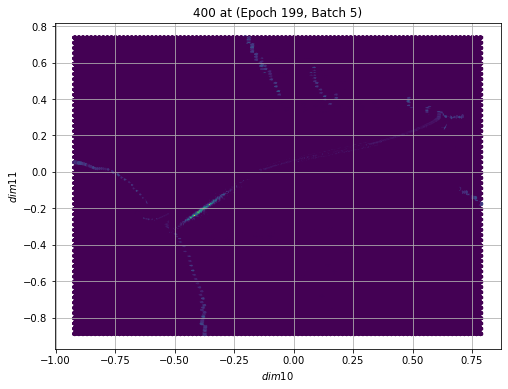

In [56]:
# Main optimization loop
all_seeds = np.linspace(1, 10, 10)
ginz_dim = rosen_dim
# for testing: delete
all_seeds = [9]


# ===
# number of epochs
num_epoch = 200
# tune batch size for good generalization error
batch_size = 2**8

# loop over all random seeds to confirm working algorithm
for seed_idx in np.arange(len(all_seeds)):
    # fix a seed
    seed = int(all_seeds[seed_idx])
    # set random seed
    np.random.seed(int(seed))
    # restart NN
    ginz_flow = NormalizingFlow(dim=ginz_dim, blocks=None, flow_length=8, density=None)
    # Create optimizer algorithm
    optimizer = optim.Adam(ginz_flow.parameters(), lr=1e-3)
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
    # begin training
    num_subplot = 0
    all_losses = []
    all_test_losses = []
    # save figure in individual folders for each seed
    seed_path = "./img/birosen/seed{}".format(seed)
    if not os.path.isdir(seed_path):
        os.mkdir(seed_path)
    for epoch in range(num_epoch):
        # # # # # # # # # #
        # Data Preproc
        # # # # # # # # # #
        permutation = torch.randperm(num_samples)
        for it in range(0, num_samples, batch_size):
            batch_number = it // batch_size
            # Draw a random sample batch from "base" (the truncated TT samples, in training data)
            sample_idx = permutation[it:it + batch_size]
            #np.random.choice(training_data.shape[0], batch_size)
            samples = torch.Tensor(training_data[sample_idx,:])
            log_base_prob = torch.Tensor(log_training_data_densities[sample_idx, :]).reshape(-1,1)

            # flow this sample
            zk, log_jacobians = ginz_flow(samples)

            # volume correction (approximate dist.)
            log_base_prob = log_base_prob.reshape(-1)
            base_prob = log_base_prob
            ### visual reporting
            if (it % 10 == 0):
                # plot the flowed samples
                num_subplot += 1
                plt.figure(2, figsize=(8,6));
                plt.grid(True); 
                plt.xlabel("$dim {}$".format(ginz_dim-1)); 
                plt.ylabel("$dim {}$".format(ginz_dim)); 
                plt.title("{} at (Epoch {}, Batch {})".format(num_subplot, epoch, batch_number));
                # pick a sample from training data, flow, and plot it
                data_idx = np.random.randint(0, training_data.shape[0], 10*num_samples)
                plot_data = torch.Tensor(training_data[data_idx, :])
                flowed_plot_data, _ = ginz_flow(plot_data)
                flowed_plot_data = flowed_plot_data.detach().numpy()
                plt.hexbin(flowed_plot_data[:,ginz_dim-2], flowed_plot_data[:,ginz_dim-1]);
                ##########
                # save figure in individual folders for each seed
                if use_gaussian_prior:
                    plt.savefig("./img/birosen/seed{}/seed{}_rosen_scal_gaussian_prior".format(seed, \
                                                                                                  seed) + \
                                "_batchsz{}_epoch{}_batch{}".\
                                format(batch_size, epoch, it))
                else:
                    plt.savefig("./img/birosen/seed{}/seed{}_rosen_tt_prior".format(seed, seed) + \
                                "_batchsz{}_epoch{}_batch{}".\
                                format(batch_size, epoch, it))

            # clean optimizer
            optimizer.zero_grad()
            # compute loss of on the flowed sample
            loss_v = loss_kl_3(base_prob, double_rosen, samples, zk, log_jacobians)
            # backprop of NN
            loss_v.backward()

            optimizer.step()
            scheduler.step()
            # compute test loss (do not use backward on this part)
            # flow all test data to evaluate loss
            samples_test = torch.Tensor(test_data)
            samples_test_likelihoods = torch.Tensor(log_test_data_densities).reshape(-1, 1)
            zk_test, log_jacobians_test = ginz_flow(samples_test)
            loss_test = loss_kl_3(samples_test_likelihoods, double_rosen, \
                                  samples_test, zk_test, log_jacobians_test)
                
            if batch_number % 5 == 0:
                print("(Epoch {}, Batch {}) Negtive Log-Likelihood Training Err: {}".format(epoch, \
                                                                                            batch_number, \
                                                                                              loss_v.item()))

                print("(Epoch {}, Batch {}) Negtive Log-Likelihood Generalization Err: {}".format(epoch,\
                                                                                                  batch_number, \
                                                                                        loss_test.item()))
            # for plotting loss
            all_losses.append(loss_v.item())
            all_test_losses.append(loss_test.item())
    # after training for this seed, output losses
    save_dict = {"seed": seed, "training_loss": all_losses, \
                 "test_loss": all_test_losses, "bc_sz: ": batch_size, \
                "num_epoch": num_epoch}
    save_filename = "./report/birosen/seed{}_report.mat".format(seed)
    scipy.io.savemat(save_filename, save_dict)
    # after training, save model
    model_path = "./report/birosen/seed{}_trained_model.pkl".format(seed)
    torch.save(ginz_flow, model_path)

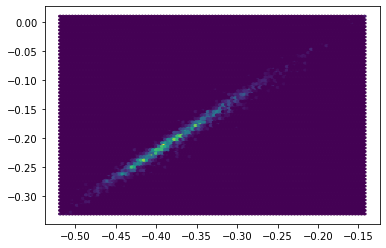

In [57]:
# plot last flowed sample
data_idx = np.random.randint(0, training_data.shape[0], 10*num_samples)
plot_data = torch.Tensor(training_data[data_idx, :])
flowed_plot_data, _ = ginz_flow(plot_data)
flowed_plot_data = flowed_plot_data.detach().numpy()
plt.hexbin(flowed_plot_data[:,ginz_dim-2], flowed_plot_data[:,ginz_dim-1]);

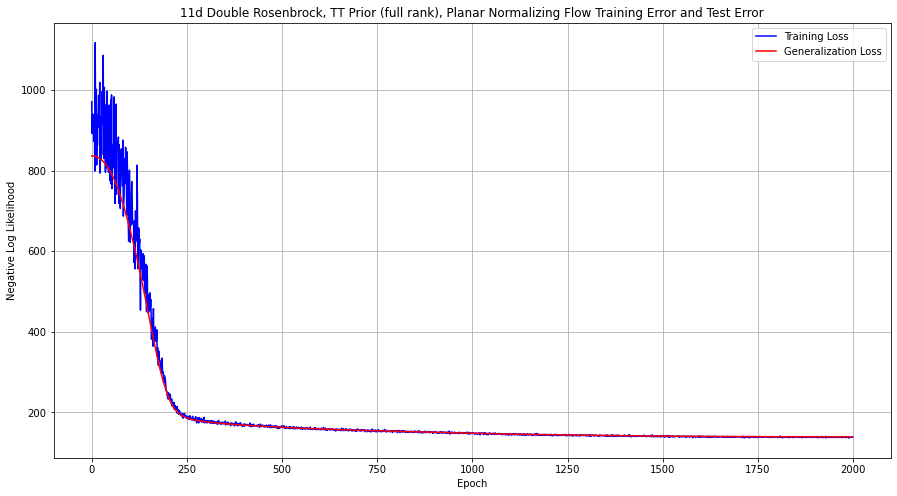

In [58]:
# plot training loss
plt.figure(1, figsize=(15, 8))
plt.plot(all_losses, color="blue", label="Training Loss")
plt.plot(all_test_losses, color="red", label="Generalization Loss")
plt.title("11d Double Rosenbrock, TT Prior (full rank), Planar Normalizing Flow Training Error and Test Error")
plt.grid(True);
plt.xlabel("Epoch");
plt.ylabel("Negative Log Likelihood");
plt.legend();

In [48]:
save_filename = "./report/birosen/seed{}_report.mat".format(seed)
scipy.io.savemat(save_filename, save_dict)

FileNotFoundError: [Errno 2] No such file or directory: './report/birosen/seed9_report.mat'

In [52]:
len(all_losses)

200